In [87]:
from shapely import *
import shapely.plotting as splt
import shapely.ops as sopt
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# split room into points, create cells around each points, and determine the adjacency of these cells 

# create a room 
# create offset curve to describe surroundings, and make it into a polygon 
# use numpy to make a mesh of points that are evenly distributed 
# use buffer to create cells based on these points and the overlap/ intersection with the polygons 
# give cells properties based on their relation to the room/surroundings...
# use str tree thing to identify neighbours of each cell 

In [89]:
# create a room 
room_lx = 20 #m - length in x
room_ly= 10 #m 
room_poly = box(0.0, 0.0, room_lx, room_ly)

In [49]:
# use buffer to describe ambient 
amb_poly = room_poly.buffer(1, cap_style="square", join_style="mitre")

In [98]:
# use numpy to make a mesh of points that are evenly distributed 
room_xy = room_poly.exterior.coords.xy

num_points = 5
x = np.linspace(np.min(room_xy[0]), np.max(room_xy[0]), num_points)
y = np.linspace(np.min(room_xy[1]), np.max(room_xy[1]), num_points)
xv, yv = np.meshgrid(x,y)

room_pts = [(x,y) for x,y in zip(xv.flatten(), yv.flatten())]

In [119]:
def box_from_centroid(centroid, dx, dy):
    # centroid should be a tuple
    # create a box based on a centroid with coordinates going in ccw direction (starting from top-left => v1, v2, v3, v4 <= top right)
    cx, cy = centroid

    v1x = v2x = cx - dx/2
    v4x = v3x = cx + dx/2

    v1y = v4y = cy - dy/2
    v2y = v3y = cy + dy/2

    coords = (
        (v1x, v1y),
        (v2x, v2y),
        (v3x, v3y),
        (v4x, v4y)
    )

    return Polygon(coords)


In [135]:
# create cells around points in mesh of points 
dx = room_lx/(num_points - 1)
dy = room_ly/(num_points - 1)
cells = [box_from_centroid(pt, dx, dy) for pt in room_pts]

#all cells should have the same area 
assert len(np.unique(np.array([cell.area for cell in cells2]))) == 1


In [188]:
# edit cell geometries based on overlap with room geom 
cells_trimmed = {}
for ix, cell in enumerate(cells):
    if not cell.within(room_poly):
        cells_trimmed[ix] = cell.intersection(room_poly)
    else:
        cells_trimmed[ix] = cell


In [190]:
# find the neighbours of each cell - those that have overlapping boundaries (not just points)
tree = STRtree(list(cells_trimmed.values()))


cells_nb = {} # nb - neighbours
nb_pattern = 'FF2F11212' # used relate function to id DE-9IM pattern

for k,v in cells_trimmed.items(): 
    cells_nb[k] = []
    near_cells_ix = tree.query(v).tolist() 

    for ix in near_cells_ix:
        if v.relate_pattern(cells_trimmed[ix], nb_pattern):
            cells_nb[k].append(ix)


    

In [191]:
cells_nb

{0: [1, 5],
 1: [0, 2, 6],
 2: [1, 3, 7],
 3: [2, 4, 8],
 4: [3, 9],
 5: [0, 6, 10],
 6: [1, 5, 11, 7],
 7: [2, 6, 12, 8],
 8: [3, 7, 9, 13],
 9: [4, 8, 14],
 10: [5, 11, 15],
 11: [6, 10, 12, 16],
 12: [11, 7, 13, 17],
 13: [12, 8, 14, 18],
 14: [9, 13, 19],
 15: [10, 16, 20],
 16: [11, 15, 17, 21],
 17: [12, 16, 18, 22],
 18: [13, 17, 19, 23],
 19: [14, 18, 24],
 20: [15, 21],
 21: [16, 22, 20],
 22: [17, 21, 23],
 23: [18, 22, 24],
 24: [19, 23]}

### visuals

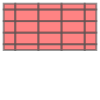

In [144]:
MultiPolygon(cells_trimmed)

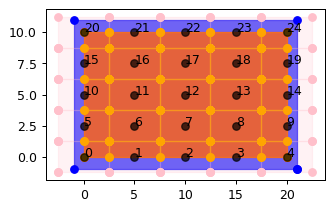

In [163]:
GM = (np.sqrt(5)-1.0)/2.0
W = 4
H = W*GM
SIZE = (W, H)

fig = plt.figure(figsize=SIZE,  dpi=90)
ax = fig.add_subplot(111)


splt.plot_polygon(amb_poly, ax=ax, alpha=0.7, color="blue")
splt.plot_polygon(room_poly, ax=ax, alpha=0.7, color="red")



for cell in cells:
    splt.plot_polygon(cell, ax=ax, alpha=0.2, color="pink")

for (name, cell), pt in zip(cells_trimmed.items(),room_pts):
    splt.plot_polygon(cell, ax=ax, alpha=0.4, color="orange")
    ax.annotate(name, pt)


splt.plot_points(MultiPoint(room_pts), ax=ax, alpha=0.7, color="black")